# Face Classification

Classifying the `yaleFaceDatabaseB` dataset using PCA for dimension reduction followed by k-NN classifier.

In [1]:
# import required libraries
import imageio                    # for reading image datasets
import numpy as np                # for dealing with arrays/vectors/matrices
from os import listdir            # for reading subfolders in folders
import matplotlib.pyplot as plt   # for plotting/displaying graphs and images
from sklearn.neighbors import KNeighborsClassifier as knn

%matplotlib inline

In [2]:
# load dataset
DATASET_FOLDER = "yaleBfaces"
NUM_SUBSETS = 5
IMG_HEIGHT, IMG_WIDTH = 50, 50
BITS_PER_PIXEL = 8
MAX_PIXEL_VALUE = 2**BITS_PER_PIXEL - 1    # any number represented by n bits 
                                           # can have a maximum value of (2^n -1)

data_subset_indices = np.arange(NUM_SUBSETS)
data_images = {}
data_labels = {}

for index in data_subset_indices:
    sub_folder = "subset" + str(index)
    # get all image names inside sub_folders
    image_names = listdir(DATASET_FOLDER + "/" + sub_folder)
    
    num_images = len(image_names)
    data_images[index] = np.zeros((IMG_HEIGHT*IMG_WIDTH, num_images))
    data_labels[index] = np.zeros(num_images)
    
    # load all files into particular subset
    image_index = 0
    for image_name in image_names:
        image_directory = DATASET_FOLDER + "/" + sub_folder + "/" + image_name
        image = imageio.imread(image_directory)
        image_vector = np.reshape(image, (IMG_HEIGHT*IMG_WIDTH))
        normalized_image_vector = image_vector/MAX_PIXEL_VALUE
        data_images[index][:, image_index] = normalized_image_vector
        data_labels[index][image_index] = int(image_name[6:8])
        image_index += 1

In [3]:
# Function which takes in matrix T and returns 20 first singular vectors
def pca(X, k):
    # calculate mean of images
    mu = np.mean(X, axis=1)[:, np.newaxis]
    # centering
    X_ = X - mu
    # SVD
    U, Sigma, VT = np.linalg.svd(X_, full_matrices = False)
    # keep only first k singular vectors in U
    Uk = U[:, :k]
    return Uk, mu

In [4]:
# Apply function to subset 0
X = data_images[0]
y = data_labels[0]
k = 20
Uk, mu = pca(X, k)

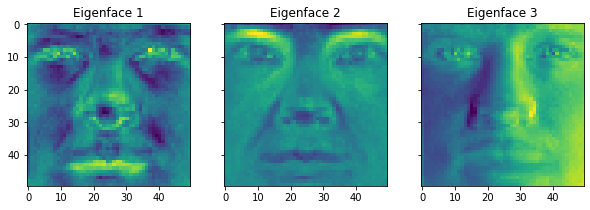

In [5]:
# Display first three prinicipal component vectors as images
NUM_DISPLAY = 3

# plot resulting principal components
f, axarr = plt.subplots(ncols=NUM_DISPLAY, sharey=True, figsize=(10,3))
for col in range(0, NUM_DISPLAY):
    axarr[col].set_title('Eigenface ' + str(col + 1))
    u = Uk[:, col]
    u_image = np.reshape(u, (IMG_HEIGHT, IMG_WIDTH))
    axarr[col].imshow(u_image)

plt.show()

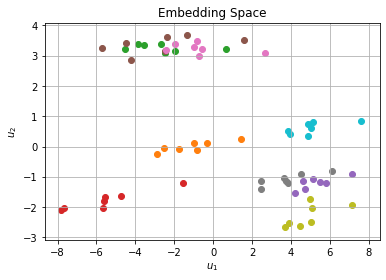

In [6]:
X_ = X - mu
Z = Uk.T @ X_

for i in range(10):
    Zi = Z[:, y == i*1.0]
    plt.scatter(Zi[0, :], Zi[1, :])
plt.title('Embedding Space')
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.grid()

In [7]:
# function for returning classifier and respective test accuracy

def classify(X, y, X_test, y_test, Uk, mu, k, n=3):
    NUM_NEIGHBORS = n
    classifier = knn(n_neighbors = NUM_NEIGHBORS)
    Uk = Uk[:, :k]
    
    # fit classifier on training set
    X_ = X - mu
    Z = Uk.T @ X_
    classifier.fit(Z.T, y)
    # calculate test accuracy/ error
    X_test_ = X_test - mu
    Z_test = Uk.T @ X_test_
    accuracy = classifier.score(Z_test.T, y_test)
    
    return classifier, accuracy

In [8]:
# calculate errors for each subset and k value

k_vals = range(1, k)
acc = {}

# loop through all test sets
for index in data_subset_indices:

    acc[index] = np.zeros(len(k_vals))
    
    # calculate accuracy for increasing k
    index_counter = 0
    for k in k_vals:
        X_test = data_images[index]
        y_test = data_labels[index]
        _, accuracy = classify(X, y, X_test, y_test, Uk, mu, k)
        acc[index][index_counter] = accuracy
        index_counter += 1

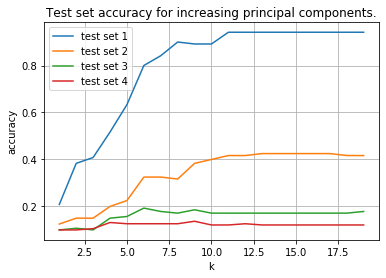

In [9]:
for val in data_subset_indices[1:]:
    plt.plot(k_vals, acc[val], label='test set ' + str(val))

plt.title('Test set accuracy for increasing principal components.')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
    
plt.show()

In [10]:
# change U to remove top few principal components
REMOVE_TOP_PC = 3
Uk_ = Uk[:, REMOVE_TOP_PC:]

k_vals_ = range(1, k-3)
acc_ = {}

# loop through all test sets
for index in data_subset_indices:

    acc_[index] = np.zeros(len(k_vals_))
    
    # calculate accuracy for increasing k
    index_counter = 0
    for k in k_vals_:
        X_test = data_images[index]
        y_test = data_labels[index]
        _, accuracy = classify(X, y, X_test, y_test, Uk_, mu, k)
        acc_[index][index_counter] = accuracy
        index_counter += 1

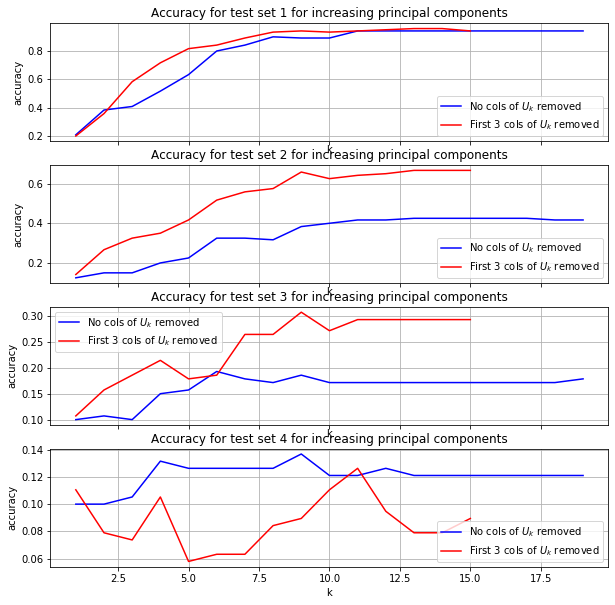

In [11]:
# plot errors

f, axarr = plt.subplots(len(data_subset_indices[1:]), sharex=True, figsize=(10,10))

subplt_index = 0
for val in data_subset_indices[1:]:
    axarr[subplt_index].plot(k_vals, acc[val], color='blue', label='No cols of $U_k$ removed')
    axarr[subplt_index].plot(k_vals_, acc_[val], color='red', label='First 3 cols of $U_k$ removed')
    axarr[subplt_index].set_title('Accuracy for test set ' + str(val) + ' for increasing principal components')
    axarr[subplt_index].set_xlabel('k')
    axarr[subplt_index].set_ylabel('accuracy')
    axarr[subplt_index].grid()
    axarr[subplt_index].legend()

    subplt_index += 1
    
plt.show()

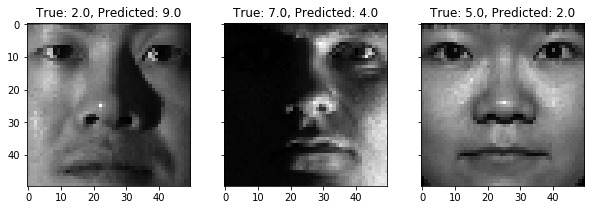

In [14]:
def inferencePipeline(x, Uk=Uk, k=10, n=3):
    NUM_NEIGHBORS = n
    classifier = knn(n_neighbors = NUM_NEIGHBORS)
    Uk = Uk[:, :k]
    
    # fit k-nn
    X_ = X - mu
    Z = Uk.T @ X_
    classifier.fit(Z.T, y)
    
    # predict label for new sample
    x_ = x[:, np.newaxis] - mu
    z = Uk.T @ x_
    y_hat = classifier.predict(z.T)
    return y_hat[0]

NUM_RANDOM_SAMPLES = 3
f, axarr = plt.subplots(ncols=NUM_RANDOM_SAMPLES, sharey=True, figsize=(10,3))
for i in range(NUM_RANDOM_SAMPLES):
    test_set_index = np.random.randint(1, 4)
    test_set_sample_index = np.random.randint(0, len(data_labels[test_set_index]))
    
    test_set = data_images[test_set_index]
    x_sample = test_set[:, test_set_sample_index]
    y_sample = data_labels[test_set_index][test_set_sample_index]
    
    y_hat = inferencePipeline(x_sample, k=2)
    
    axarr[i].set_title('True: ' + str(y_sample) + ', Predicted: ' + str(y_hat))
    axarr[i].imshow(np.reshape(x_sample, (IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
    
plt.show()